In [67]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import gwpopulation
from gwpopulation.models.redshift import MadauDickinsonRedshift
import bilby
import seaborn as sns
import pylab as plt
import os
import h5py
from sympy import symbols
import GWForge
import pycbc
import numpy as np
from scipy.signal import argrelextrema
import pandas as pd

# A-sharp

In [40]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
mass_band = 'above_80'
#mass_band = '40-80'
#mass_band = 'below_40'
run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'Asharp',
                       'mass_bands', mass_band, 'run06_gwfish_MDlow_mf_from_opt_SNR_injections_XPHM',)
#run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'Asharp', 
#                       'run11_gwfish_MDlow_mf_from_opt_SNR_injections_XPHM')

In [41]:
gwpop_result = bilby.result.read_in_result(filename=os.path.join(run_dir,
                                                                 'Asharp_result.hdf5'))
posterior_mf = gwpop_result.posterior

In [42]:
posterior_mf

,gamma,kappa,log_likelihood,log_prior,z_peak
0,1.068727,7.173381,1372.540948,-5.857933,2.843112
1,4.557703,7.081480,1375.374683,-5.857933,0.583054
2,2.470047,4.767055,1376.301442,-5.857933,1.407515
3,0.281396,12.211909,1376.323810,-5.857933,3.261713
4,3.687620,6.678666,1376.444500,-5.857933,0.984825
...,...,...,...,...,...
2590,3.428845,4.668854,1382.534964,-5.857933,0.522600
2591,2.988804,4.332048,1382.539929,-5.857933,0.530326
2592,2.594474,3.778433,1382.551474,-5.857933,0.502698
2593,2.493789,3.702286,1382.562614,-5.857933,0.503573


In [43]:
inj_pop = '5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td.h5'
#inj_pop = '4_pop_PLP_spin_prec_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td.h5'
#inj_pop = '2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_365_days_corrected_td.h5'
with h5py.File(os.path.join(project_dir, 
                            'input_population', 
                            'BBH', 
                            inj_pop), 'r') as f:
    injected_redshift = f['redshift'][:]

## Plot injected data

Text(0.5, 0, '$z$')

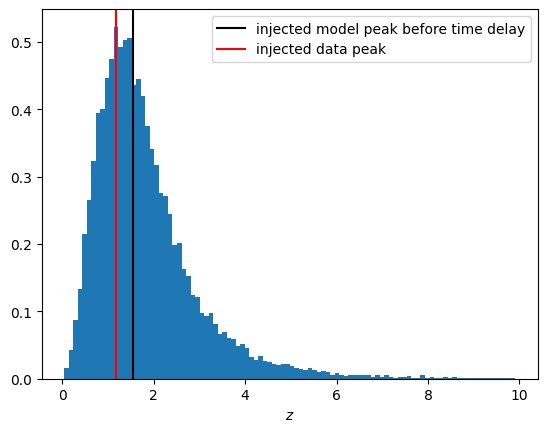

In [44]:
if 'MDhigh' in run_dir:
    inj_peak = 2.53
elif 'MDlow' in run_dir:
    inj_peak = 1.54
else:
    inj_peak = 1.9
plt.hist(injected_redshift, bins=100, density=True);
plt.axvline(inj_peak, c='k', label='injected model peak before time delay')
hData = np.histogram(injected_redshift, bins=100)
inj_z_peak_edge_idx = np.argmax(hData[0])
inj_z_peak = (hData[1][inj_z_peak_edge_idx] + hData[1][inj_z_peak_edge_idx + 1])/2
plt.axvline(inj_z_peak, c='r', label='injected data peak')
plt.legend()
plt.xlabel('$z$')

## Rebuild MDR model

In [45]:
MDR_model = MadauDickinsonRedshift(z_max=10)

In [46]:
if 'MDhigh' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 2.53}, 
                             'after_time_delay':{'gamma':1.7982, 'kappa':5.3226, 'z_peak':2.4199}}
elif 'MDlow' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.54}, 
                             'after_time_delay':{'gamma':1.8111, 'kappa':5.2753, 'z_peak':1.4917}}
else:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}, 
                             'after_time_delay':{'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}}

In [47]:
injected_hyper_params

{'before_time_delay': {'gamma': 2.7, 'kappa': 5.6, 'z_peak': 1.54},
 'after_time_delay': {'gamma': 1.8111, 'kappa': 5.2753, 'z_peak': 1.4917}}

## MF SNR injections

### Plot model at injection params vs median params

In [48]:
median_hyper_params_mf = {'gamma':np.median(posterior_mf['gamma']), 
                       'kappa':np.median(posterior_mf['kappa']), 
                       'z_peak':np.median(posterior_mf['z_peak'])}

In [49]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 10, 0.01)
posterior_median_prob_arr_mf = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params_mf)

### Plot posterior bands

In [50]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior_mf['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior_mf[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [51]:
z_grid = np.arange(0, 10, 0.01)
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

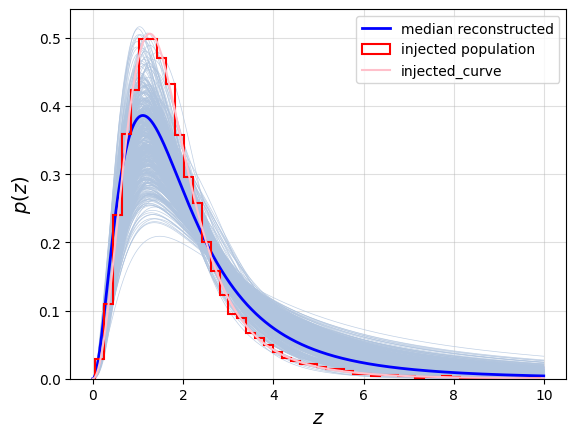

In [52]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed', c='b', lw=2)
plt.hist(injected_redshift, bins=50, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend(loc=1)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)
plt.savefig(os.path.join(run_dir, 'reconstructed_z.png'), dpi=300)

### Plot prior bands

In [38]:
n_samples = 500
prior_samples = gwpop_result.priors.sample(n_samples)
prior_sample_records = pd.DataFrame(prior_samples).to_dict(orient='records')

In [39]:
prior_prob_arr_list = []
for rec in prior_sample_records:
    prior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

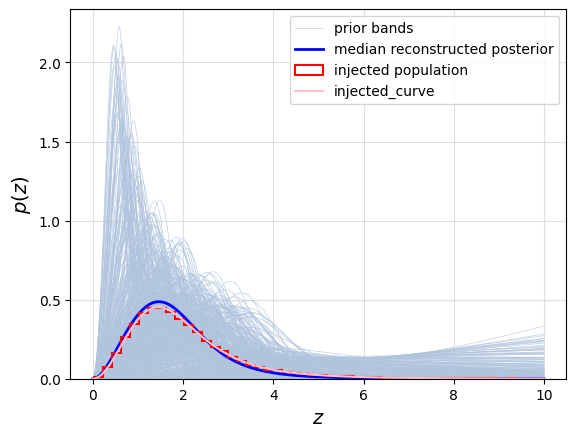

In [71]:
for j, i in enumerate(prior_prob_arr_list):
    if j == 0:
        plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5, label='prior bands')
    else:
        plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed posterior', c='b', lw=2)
plt.hist(injected_redshift, bins=50, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend(loc=1)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)

# CE4020ET123

In [68]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#mass_band = 'below_40'
#mass_band = '40-80'
mass_band = 'above_80'
if 'mass_band' in locals():
    print('Running for mass_band', mass_band)
    run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                           'CE4020ET123', 'mass_bands', mass_band, 'run04_gwfish_MDlow_mf_from_opt_SNR_injections_XPHM')
else:
    run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                           'CE4020ET123', 'run18_gwfish_mf_from_opt_SNR_injections_XPHM')
print(run_dir)

Running for mass_band above_80
/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/CE4020ET123/mass_bands/above_80/run04_gwfish_MDlow_mf_from_opt_SNR_injections_XPHM


In [69]:
gwpop_result_mf_injs = bilby.result.read_in_result(filename=os.path.join(run_dir, 
                                                                         'CE4020ET123_result.hdf5'))
posterior_mf = gwpop_result_mf_injs.posterior

In [70]:
posterior_mf

,gamma,kappa,log_likelihood,log_prior,z_peak
0,2.562569,7.985664,411.158288,-5.857933,1.674207
1,0.315705,2.168886,411.618703,-5.857933,3.426871
2,1.657474,3.913123,411.634900,-5.857933,2.036111
3,0.490335,15.242996,412.104547,-5.857933,3.982105
4,1.173646,7.875105,412.274692,-5.857933,3.034971
...,...,...,...,...,...
2654,0.038972,3.371357,418.716297,-5.857933,2.266474
2655,0.040880,3.458448,418.716818,-5.857933,2.358500
2656,0.001698,3.740512,418.718667,-5.857933,2.605517
2657,0.014946,3.464752,418.719049,-5.857933,2.421666


In [71]:
if 'MDlow' in run_dir:
    pop_str = '5_pop_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td.h5'
elif 'MDhigh' in run_dir:
    pop_str = '4_pop_PLP_spin_prec_fref_5_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td.h5'
else:
    pop_str = '2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_365_days_corrected_td.h5'
with h5py.File(os.path.join(project_dir, 
                            'input_population', 
                            'BBH', 
                            pop_str), 'r') as f:
    injected_redshift = f['redshift'][:]

## Plot injected data

Text(0.5, 0, '$z$')

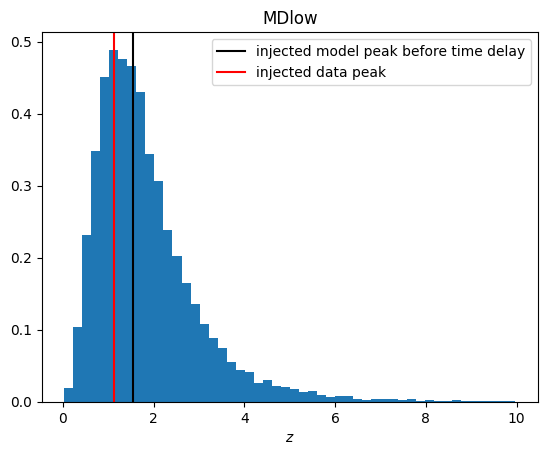

In [72]:
if 'MDhigh' in run_dir:
    inj_peak = 2.53
elif 'MDlow' in run_dir:
    inj_peak = 1.54
else:
    inj_peak = 1.9
plt.hist(injected_redshift, bins=50, density=True);
plt.axvline(inj_peak, c='k', label='injected model peak before time delay')
hData = np.histogram(injected_redshift, bins=50)
inj_z_peak_edge_idx = np.argmax(hData[0])
inj_z_peak = (hData[1][inj_z_peak_edge_idx] + hData[1][inj_z_peak_edge_idx + 1])/2
plt.axvline(inj_z_peak, c='r', label='injected data peak')
plt.legend()
plt.title(pop_str.split('_z_')[-1].split('_')[0])
plt.xlabel('$z$')

## Rebuild MDR model

In [73]:
MDR_model = MadauDickinsonRedshift(z_max=10)

In [74]:
if 'MDhigh' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 2.53}, 
                             'after_time_delay':{'gamma':1.7982, 'kappa':5.3226, 'z_peak':2.4199}}
elif 'MDlow' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.54}, 
                             'after_time_delay':{'gamma':1.8111, 'kappa':5.2753, 'z_peak':1.4917}}
else:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}, 
                             'after_time_delay':{'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}}

## MF SNR injections

### Plot model at injection params vs median params

In [75]:
median_hyper_params_mf = {'gamma':np.median(posterior_mf['gamma']), 
                       'kappa':np.median(posterior_mf['kappa']), 
                       'z_peak':np.median(posterior_mf['z_peak'])}

In [76]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 10, 0.01)
posterior_median_prob_arr_mf = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params_mf)

### Plot posterior bands

In [77]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior_mf['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior_mf[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [78]:
z_grid = np.arange(0, 10, 0.01)
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

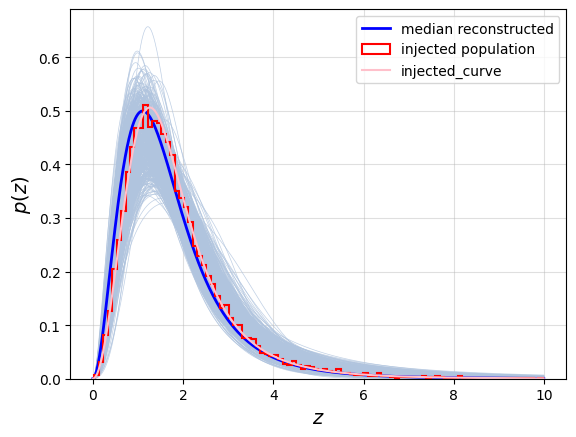

In [80]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed', c='b', lw=2)
plt.hist(injected_redshift, bins=100, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend()
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)
plt.savefig(os.path.join(run_dir, 'reconstructed_z.png'), dpi=300)